In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data import TensorDataset
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

NameError: name '_C' is not defined

In [3]:
X, y = fetch_openml('mnist_784', version=1,return_X_y=True, parser = 'auto')

In [4]:
X = X.values
y = y.astype(int).values

print(X.shape)

(70000, 784)


In [5]:
X = ((X / 255.) - 0.5) * 2

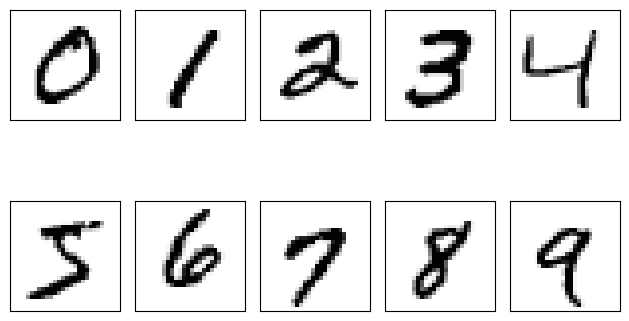

In [6]:

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

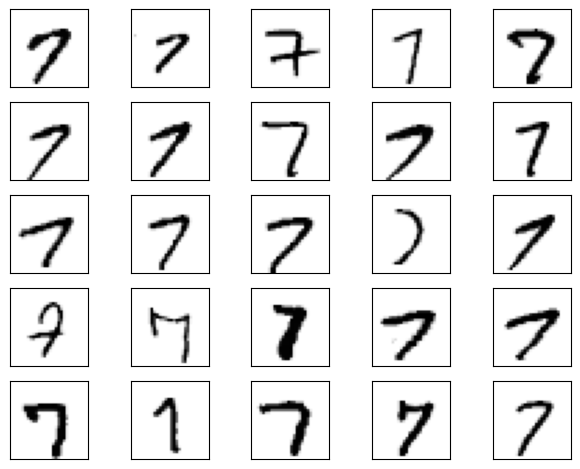

In [7]:

fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [8]:



X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

In [9]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [10]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [11]:


num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [12]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [13]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [14]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123)

epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,
                                                     num_epochs = 50, learning_rate = 0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

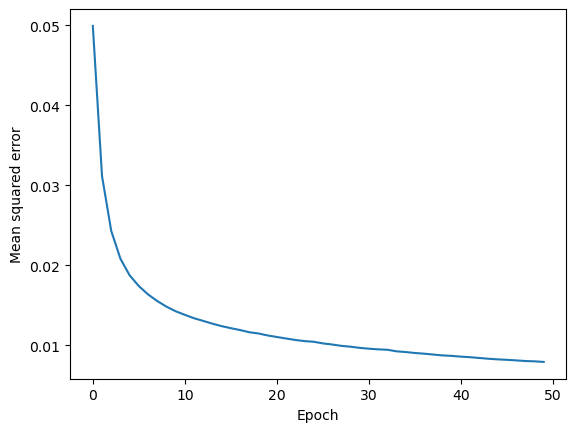

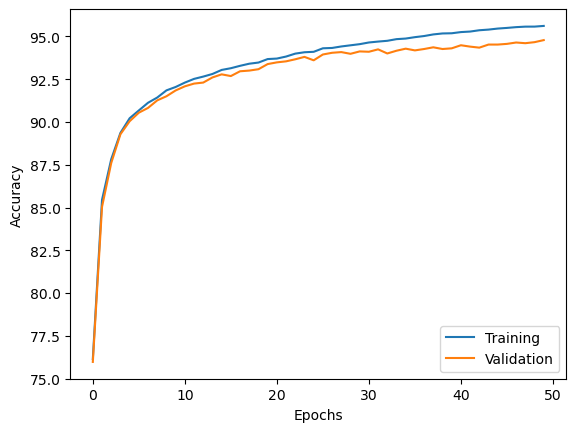

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

# CH 12 pytorch

In [18]:


np.set_printoptions(precision=3)

In [19]:
a = [1,2,3]
b = np.array([4,5,6], dtype = np.int32)

t_a = torch.tensor(a)
t_b = torch.from_numpy(b)

print(t_a)
print(t_b)

t_ones = torch.ones(2,3)
print(t_ones.shape)
print(t_ones)

tensor([1, 2, 3])
tensor([4, 5, 6], dtype=torch.int32)
torch.Size([2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [20]:
t_a_new = t_a.to(torch.int64)

print(t_a_new.dtype)

tens = torch.rand(3,5,4)
tens_tr = torch.transpose(tens,0,1)
print(tens.shape, ' --> ', tens_tr.shape)
tens_tr = torch.transpose(tens,0,2)
print(tens.shape, ' --> ', tens_tr.shape)

torch.int64
torch.Size([3, 5, 4])  -->  torch.Size([5, 3, 4])
torch.Size([3, 5, 4])  -->  torch.Size([4, 5, 3])


In [21]:
t = torch.zeros(30)
print(t)

t_reshape = t.reshape(5, 6)

print(t_reshape.shape)
print(t_reshape)

t_reshape = t.reshape(3,10)
print(t_reshape)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
torch.Size([5, 6])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [22]:
t = torch.zeros(1, 2, 1, 4, 1)

t_sqz = torch.squeeze(t, 2)

print(t.shape, ' --> ', t_sqz.shape)

t_sqz = torch.squeeze(t)

print(t.shape, ' --> ', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])
torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([2, 4])


In [23]:
t = torch.arange(6, dtype = torch.float32)
data_loader = DataLoader(t)
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [24]:
data_loader = DataLoader(t, batch_size=3, drop_last=False)
for i, batch in enumerate(data_loader,1): #the 1 here intializes the first index at 1
    print(f'batch: {i}:', batch)

batch: 1: tensor([0., 1., 2.])
batch: 2: tensor([3., 4., 5.])


In [25]:
torch.manual_seed(1)

t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)

joint_dataset = TensorDataset(t_x,t_y)

for example in joint_dataset:
    print(' x: ',example[0],
          ' y: ',example[1])

 x:  tensor([0.7576, 0.2793, 0.4031])  y:  tensor(0)
 x:  tensor([0.7347, 0.0293, 0.7999])  y:  tensor(1)
 x:  tensor([0.3971, 0.7544, 0.5695])  y:  tensor(2)
 x:  tensor([0.4388, 0.6387, 0.5247])  y:  tensor(3)


In [1]:
import os
from itertools import islice
import torch.utils
image_path = desktop_path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop/IEX/IEX_Training')
mnist_dataset = torchvision.datasets.MNIST(image_path, 'train', download = True)
assert isinstance(mnist_dataset, torch.utils.data.Dataset)
example = next(iter(mnist_dataset))
print(example)

fig = plt.figure(figsize=(15,6))
for i, (image,label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)
plt.show()

KeyboardInterrupt: 

# Chapter 12 part 2

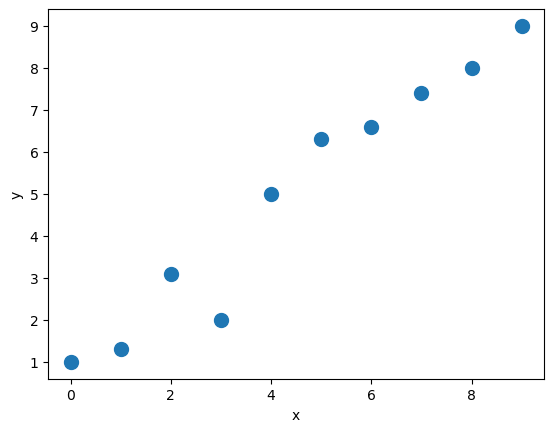

In [ ]:
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 
                    7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('figures/12_07.pdf')
plt.show()

In [ ]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)

y_train = torch.from_numpy(y_train).float()

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds,batch_size, shuffle=True)

In [ ]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1,requires_grad=True)

def model(xb):
    return xb @ weight + bias

def loss_fn(input, target):
    return (input - target).pow(2).mean()

learning_rate = 0.001
num_epochs = 200
log_epochs = 10
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        weight.grad.zero_()
        bias.grad.zero_()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}   Loss {loss.item():.4f}')

Epoch 0   Loss 46.5720
Epoch 10   Loss 27.1502
Epoch 20   Loss 1.6446
Epoch 30   Loss 14.4571
Epoch 40   Loss 11.7827
Epoch 50   Loss 6.4122
Epoch 60   Loss 0.6339
Epoch 70   Loss 3.1562
Epoch 80   Loss 2.0100
Epoch 90   Loss 0.3107
Epoch 100   Loss 0.7625
Epoch 110   Loss 1.0024
Epoch 120   Loss 0.0232
Epoch 130   Loss 0.5138
Epoch 140   Loss 0.0741
Epoch 150   Loss 1.8712
Epoch 160   Loss 0.0007
Epoch 170   Loss 0.0850
Epoch 180   Loss 0.0634
Epoch 190   Loss 0.0012


Final params: 
 m = 2.670930862426758 
 b = 4.88258695602417


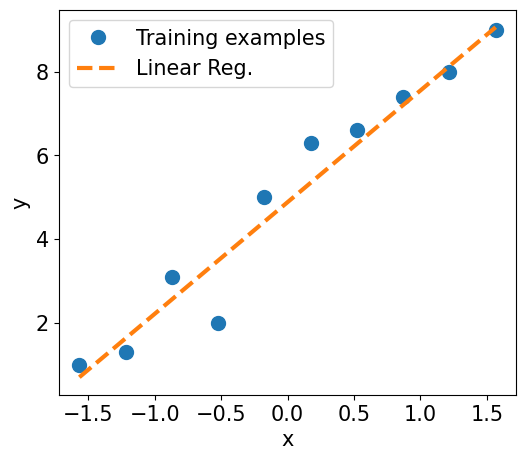

In [ ]:
print(f"Final params: \n m = {weight.item()} \n b = {bias.item()}")

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('figures/12_08.pdf')

plt.show()

In [ ]:
loss_fn = nn.MSELoss(reduction='mean')
input_size = 1
output_size = 1
learning_rate = 0.001
model = nn.Linear(input_size,output_size)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:

        pred = model(x_batch)[:, 0]

        loss = loss_fn(pred,y_batch)

        loss.backward() # computs the gradients

        optimizer.step()

        optimizer.zero_grad() #resets the gradients to 0

    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}   Loss {loss.item():.4f}')

Epoch 0   Loss 24.6684
Epoch 10   Loss 29.1377
Epoch 20   Loss 20.9207
Epoch 30   Loss 0.1257
Epoch 40   Loss 12.4922
Epoch 50   Loss 1.7845
Epoch 60   Loss 7.6425
Epoch 70   Loss 2.5606
Epoch 80   Loss 0.0157
Epoch 90   Loss 0.7548
Epoch 100   Loss 0.8412
Epoch 110   Loss 0.4923
Epoch 120   Loss 0.0823
Epoch 130   Loss 0.0794
Epoch 140   Loss 0.0891
Epoch 150   Loss 0.0973
Epoch 160   Loss 0.1043
Epoch 170   Loss 0.1103
Epoch 180   Loss 0.0009
Epoch 190   Loss 0.0764


Final Parameters: 2.6496422290802 4.87706995010376


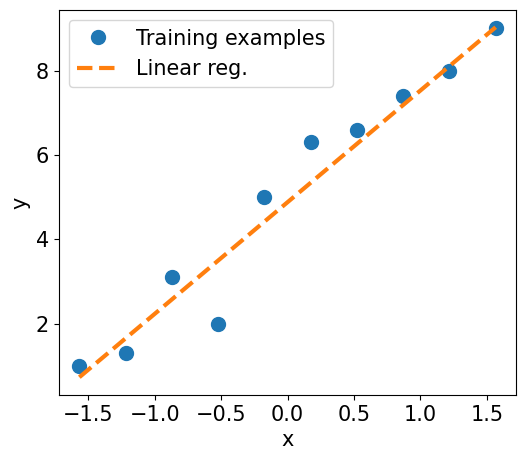

In [ ]:
print('Final Parameters:', model.weight.item(), model.bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm)

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm.detach().numpy(), y_pred.detach().numpy(), '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('ch12-linreg-2.pdf')

plt.show()

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x) #1st layer uses a sigmoid activation function
        x = self.layer2(x)
        x = nn.Softmax(dim = 1)(x) #2nd layer uses a softmax activation function
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3 #3 classes

model = Model(input_size, hidden_size, output_size)
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)


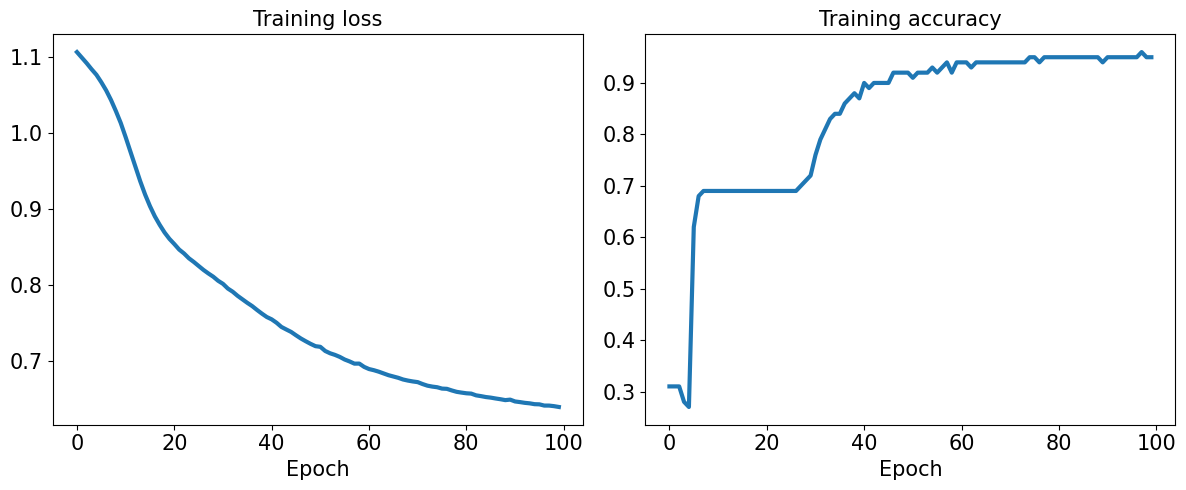

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

In [ ]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
#y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

print(pred_test.round())

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0

AttributeError: 'bool' object has no attribute 'float'

In [ ]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [ ]:
model_new = torch.load(path)
print(model_new.eval())

pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)
Test Acc.: 0.9800


In [ ]:
def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

y_class = np.argmax(Z)
print(f"Predicted class label {y_class}")

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]
Predicted class label 0


In [ ]:
# Softmax (turns the above Z into class probabilities that sum to 1)

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities \n', y_probas)
np.sum(y_probas)

Probabilities 
 [0.44668973 0.16107406 0.39223621]


1.0

# Chapter 13

## Part 1

In [ ]:
import torch

def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1,2)
    z = torch.add(r2,c)
    return Z

print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: [1.78 0.76 1.65]
Rank 1 Inputs: [1.78 0.76 1.65]
Rank 2 Inputs: [1.78 0.76 1.65]


In [ ]:
# Xavier (Glorot) Initialization

import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3)
print(w)
nn.init.xavier_normal_(w)
print(w)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [ ]:
# autograd (tensor.autograd.backward)

w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add(torch.mul(w,x),b)

loss = (y - z).pow(2).sum()
print(loss)
loss.backward() #loss value needs to be a scalar

print('dL/dw : ', w.grad) #partial derivatives with of the loss function respect to w and b
print('dL/db : ', b.grad)
# verifying the computed gradient dL/dw 
print(2 * x * ((w * x + b) - y)) #Derivative of (y - (wx + b))^2 with respect to w
#verification of dL/db
print(2 * ((w * x + b) - y)) #Derivative of (y - (wx + b))^2 with respect to b

tensor(0.0400, grad_fn=<SumBackward0>)
dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)
tensor([-0.4000], grad_fn=<MulBackward0>)


In [ ]:
# simplifying models with torch.nn.Sequential
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [ ]:
print(model[0].weight)
#nn.init.xavier_uniform_(model[0].weight)

NameError: name 'model' is not defined